In [234]:
import numpy as np
import pandas as pd
from datetime import datetime
import math
# matplotlib und seaborn für Grafiken
import matplotlib.pyplot as plt
import seaborn as sns
# sklearn für Überwachtes Lernen
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
# keras für Neuronale Netze
import keras as keras
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout 
from keras.utils.vis_utils import plot_model
# Für das Darstellen von Bildern im SVG-Format
import graphviz as gv
import pydot
#from keras.utils import model_to_dot
from IPython.display import SVG
import tensorflow as tf
from tensorflow.keras import layers

tf.__version__

'2.7.1'

In [235]:
carP_df = pd.read_csv( 'car_prices.csv',nrows=400000)

In [236]:
carP_df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,"kia motors america, inc",20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,"kia motors america, inc",20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,4.5,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,4.1,14282.0,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,4.3,2641.0,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [237]:
carP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          400000 non-null  int64  
 1   make          392910 non-null  object 
 2   model         392844 non-null  object 
 3   trim          392581 non-null  object 
 4   body          390037 non-null  object 
 5   transmission  355878 non-null  object 
 6   vin           400000 non-null  object 
 7   state         400000 non-null  object 
 8   condition     388207 non-null  float64
 9   odometer      399914 non-null  float64
 10  color         399447 non-null  object 
 11  interior      399447 non-null  object 
 12  seller        400000 non-null  object 
 13  mmr           400000 non-null  int64  
 14  sellingprice  400000 non-null  int64  
 15  saledate      400000 non-null  object 
dtypes: float64(2), int64(3), object(11)
memory usage: 48.8+ MB


In [238]:
#Fehlende Werte erkennen. Gibt ein boolesches Objekt zurück, das angibt, ob die Werte NA sind 
carP_df.isna().sum().sort_values(ascending=False)

transmission    44122
condition       11793
body             9963
trim             7419
model            7156
make             7090
color             553
interior          553
odometer           86
year                0
vin                 0
state               0
seller              0
mmr                 0
sellingprice        0
saledate            0
dtype: int64

In [239]:
#Ab diesen Abschnitt werden die fehlenden Werte je nach Datentyp der Spalte. 
# \ Kategorische Spalten -> Modus \ Kontinuierliche Spalten -> Mittelwert/Median \ Diskrete Spalten -> Modus


categorical_columns = []
continous_columns = []
discrete_columns = []

for x in carP_df.columns:
  if carP_df[x].dtypes == 'O':
    categorical_columns.append(x)
  else:
    if carP_df[x].nunique()>20:
      continous_columns.append(x)
    else:
      discrete_columns.append(x)

In [240]:
categorical_columns

['make',
 'model',
 'trim',
 'body',
 'transmission',
 'vin',
 'state',
 'color',
 'interior',
 'seller',
 'saledate']

In [241]:
#Füllen fehlender Werte kategorischer Spalten mit Modus
for x in categorical_columns:
  carP_df[x].fillna(carP_df[x].mode()[0],inplace=True)

In [242]:
y_label = 'sellingprice'

In [243]:
# Make a dictionary with int64 featureumns as keys and np.int32 as values
int_32 = dict.fromkeys(carP_df.select_dtypes(np.int64).columns, np.int32)
# Change all columns from dictionary
carP_df = carP_df.astype(int_32)

# Make a dictionary with float64 columns as keys and np.float32 as values
float_32 = dict.fromkeys(carP_df.select_dtypes(np.float64).columns, np.float32)
carP_df = carP_df.astype(float_32)

In [244]:
int_32

{'year': numpy.int32, 'mmr': numpy.int32, 'sellingprice': numpy.int32}

In [245]:
# In String umwandeln

# Eine Liste aller kategorischen Variablen erstellen
cat_convert = ['make', 'model', 'trim', 'body', 'transmission', 'vin', 'state', 'color', 'interior', 'seller', 'saledate']

# convert variables
for i in cat_convert:
    carP_df[i] = carP_df[i].astype("string")

In [246]:
# In kategorische Variablen umwandeln

# Eine Liste aller kategorischen Variablen erstellen
cat_convert = ['year', 'mmr']

# convert variables
for i in cat_convert:
    carP_df[i] = carP_df[i].astype("category")

In [247]:
carP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   year          400000 non-null  category
 1   make          400000 non-null  string  
 2   model         400000 non-null  string  
 3   trim          400000 non-null  string  
 4   body          400000 non-null  string  
 5   transmission  400000 non-null  string  
 6   vin           400000 non-null  string  
 7   state         400000 non-null  string  
 8   condition     388207 non-null  float32 
 9   odometer      399914 non-null  float32 
 10  color         400000 non-null  string  
 11  interior      400000 non-null  string  
 12  seller        400000 non-null  string  
 13  mmr           400000 non-null  category
 14  sellingprice  400000 non-null  int32   
 15  saledate      400000 non-null  string  
dtypes: category(2), float32(2), int32(1), string(11)
memory usage: 39.3 MB


In [248]:
# Liste aller numerischen Daten erstellen (außer Bezeichnung)
list_num = carP_df.drop(columns=[y_label]).select_dtypes(include=[np.number]).columns.tolist()

# Erstellen Sie eine Liste aller kategorialen Daten, die als Ganzzahlen gespeichert sind (außer Label).
list_cat_int = carP_df.drop(columns=[y_label]).select_dtypes(include=['category']).columns.tolist()

# Liste aller kategorischen Daten erstellen, die als String gespeichert sind (außer Label)
list_cat_string = carP_df .drop(columns=[y_label]).select_dtypes(include=['string']).columns.tolist()

# Data splitting

In [249]:
# Validierungsdaten erstellen
df_val = carP_df.sample(frac=0.2, random_state=1337)

# Trainingsdaten erstellen
df_train = carP_df.drop(df_val.index)

In [250]:
print(
    "Using %d samples for training and %d for validation"
    % (len(df_train), len(df_val))
)

Using 320000 samples for training and 80000 for validation


# Transform to Tensors

In [251]:
# Define a function to create our tensors

def dataframe_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop(y_label)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    df = ds.prefetch(batch_size)
    return ds

In [252]:
batch_size = 32

ds_train = dataframe_to_dataset(df_train, shuffle=True, batch_size=batch_size)
ds_val = dataframe_to_dataset(df_val, shuffle=True, batch_size=batch_size)

In [253]:
#Feature preprocessing

In [254]:
# Define numerical preprocessing function
def get_normalization_layer(name, dataset):
    
    # Create a Normalization layer for our feature
    normalizer = layers.Normalization(axis=None)

    # Prepare a dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    return normalizer

# Categorical preprocessing functions¶

In [255]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [256]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [257]:
all_inputs = []
encoded_features = []

In [258]:
# Numerical features
for feature in list_num:
  numeric_feature = tf.keras.Input(shape=(1,), name=feature)
  normalization_layer = get_normalization_layer(feature, ds_train)
  encoded_numeric_feature = normalization_layer(numeric_feature)
  all_inputs.append(numeric_feature)
  encoded_features.append(encoded_numeric_feature)

# Categorical preprocessing¶

In [259]:
for feature in list_cat_int:
  categorical_feature = tf.keras.Input(shape=(1,), name=feature, dtype='int32')
  encoding_layer = get_category_encoding_layer(name=feature,
                                               dataset=ds_train,
                                               dtype='int32',
                                               max_tokens=5)
  encoded_categorical_feature = encoding_layer(categorical_feature)
  all_inputs.append(categorical_feature)
  encoded_features.append(encoded_categorical_feature)

In [260]:
for feature in list_cat_string:
  categorical_feature = tf.keras.Input(shape=(1,), name=feature, dtype='string')
  encoding_layer = get_category_encoding_layer(name=feature,
                                               dataset=ds_train,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_feature = encoding_layer(categorical_feature)
  all_inputs.append(categorical_feature)
  encoded_features.append(encoded_categorical_feature)

In [261]:
# Input
all_features = layers.concatenate(encoded_features)

# First layer
x = layers.Dense(64, activation="relu")(all_features)

# Dropout to prevent overvitting
x = layers.Dropout(0.8)(x)

# Output layer
output = layers.Dense(1, activation="sigmoid")(x)

# Group all layers 
model = tf.keras.Model(all_inputs, output)

# Model.compile konfiguriert das Modell für das Training:

    Optimierer: Der Mechanismus, durch den sich das Modell auf der Grundlage der Trainingsdaten selbst aktualisiert, um seine Leistung zu verbessern. Eine gängige Option für den Optimierer ist Adam, eine stochastische Gradientenabstiegsmethode, die auf der adaptiven Schätzung von Momenten erster und zweiter Ordnung beruht.

    Verlust: Die Art und Weise, wie das Modell seine Leistung anhand der Trainingsdaten messen kann und wie es sich somit selbst in die richtige Richtung lenken kann. Das bedeutet, dass der Zweck von Verlustfunktionen darin besteht, die Größe zu berechnen, die ein Modell während des Trainings zu minimieren versuchen sollte.

    Metriken: Eine Metrik ist eine Funktion, die verwendet wird, um die Leistung Ihres Modells während des Trainings und der Tests zu beurteilen. Hier geht es nur um die Genauigkeit.

In [262]:
model.compile(optimizer="adam", 
              loss ="binary_crossentropy", 
              metrics=["accuracy"])

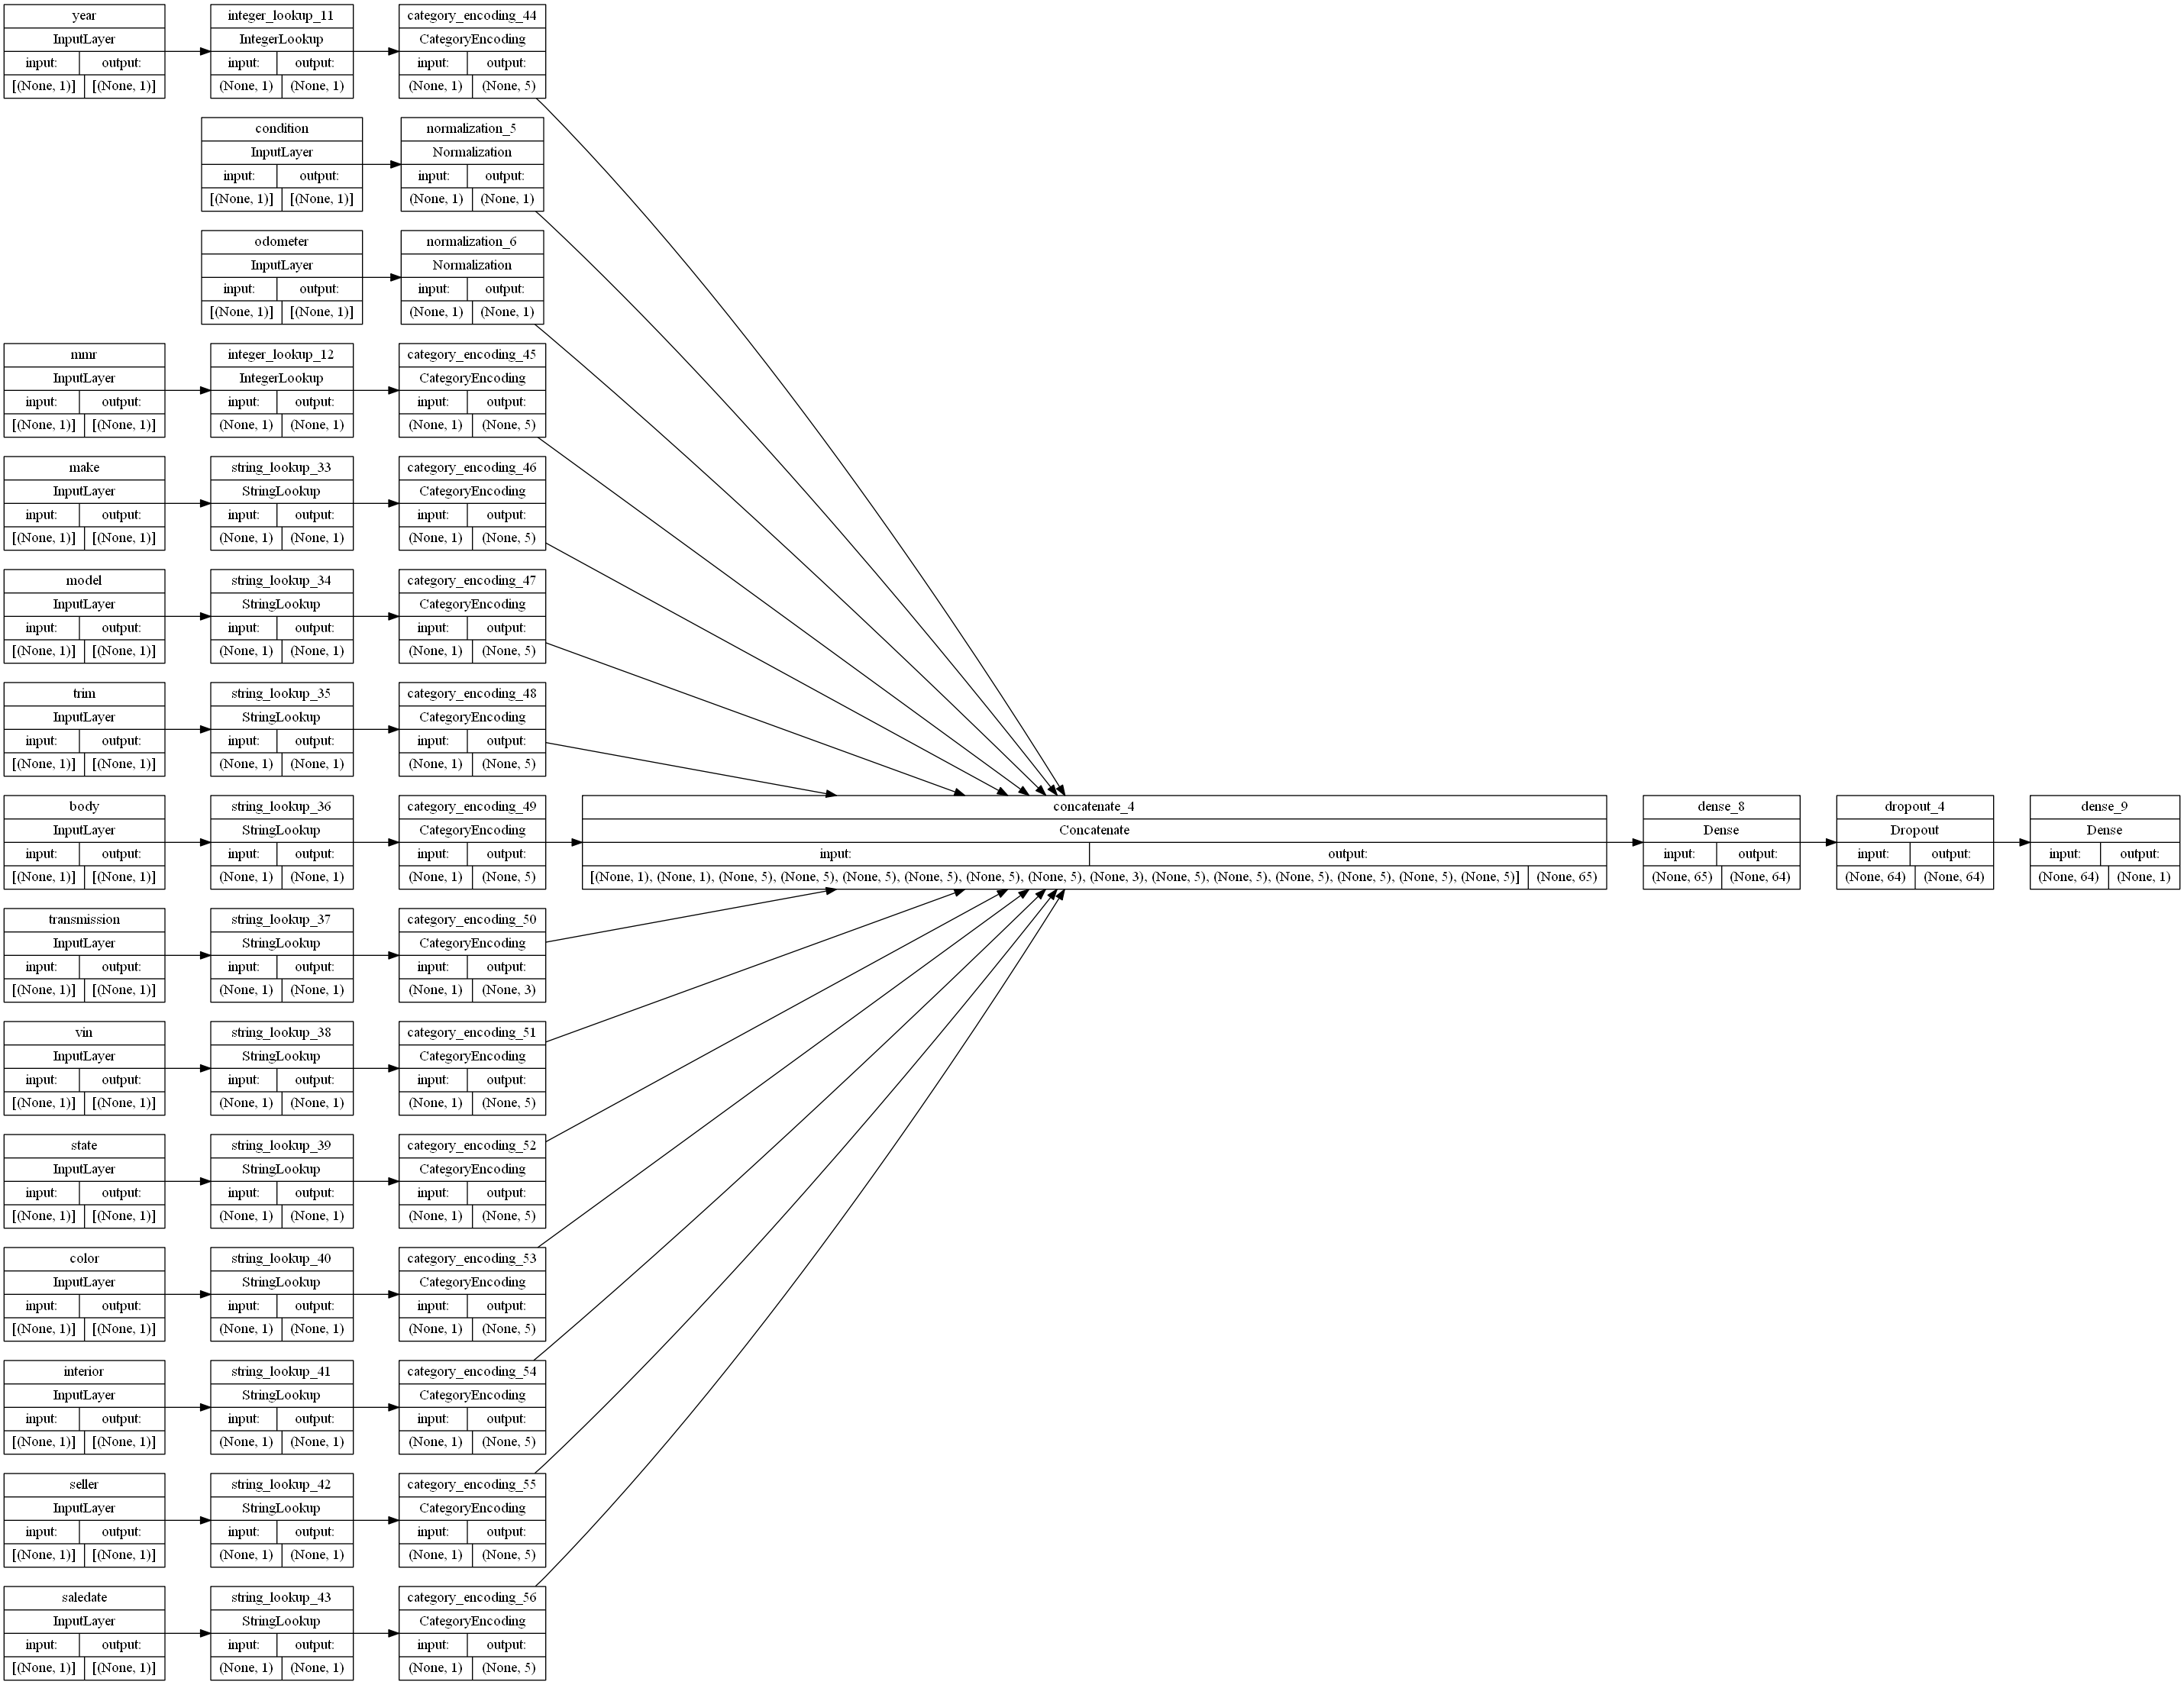

In [263]:
# `rankdir='LR'` is to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [264]:
model.fit(ds_train, epochs=10, validation_data=ds_val)

Epoch 1/10
10000/10000 [==============================] - 102s 9ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/10
10000/10000 [==============================] - 77s 7ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/10
10000/10000 [==============================] - 65s 6ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/10
10000/10000 [==============================] - 99s 9ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/10
10000/10000 [==============================] - 85s 8ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/10
10000/10000 [==============================] - 97s 9ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/10
10000/10000 [==============================] - 93s 9ms/step - loss: nan - accuracy: 0.0000e+00

In [265]:
loss, accuracy = model.evaluate(ds_val)

print("Accuracy", round(accuracy, 2))

2500/2500 [==============================] - 13s 5ms/step - loss: nan - accuracy: 0.0000e+00
Accuracy 0.0
